In [5]:
import seaborn as sns
sns.set()

# ML: Predicting Star Ratings


Our objective is to predict a new venue's popularity from information available when the venue opens.  We will do this by machine learning from a data set of venue popularities provided by Yelp.  The data set contains meta data about the venue (where it is located, the type of food served, etc.).  It also contains a star rating. Note that the venues are not limited to restaurants.

## Download and parse the incoming data


We start by downloading the data set from Amazon S3:

In [4]:
!aws s3 sync s3://mldata/ . --exclude '*' --include 'yelp_train_academic_dataset_business.json.gz'

The training data are a series of JSON objects, in a Gzipped file. Python supports Gzipped files natively: [`gzip.open`](https://docs.python.org/3/library/gzip.html) has the same interface as `open`, but handles `.gz` files automatically.

The built-in `json` package has a `loads` function that converts a JSON string into a Python dictionary. We could call that once for each row of the file. [`ujson`](http://docs.micropython.org/en/latest/library/ujson.html) has the same interface as the built-in `json` package, but is *substantially* faster (at the cost of non-robust handling of malformed JSON). We will use that inside a list comprehension to get a list of dictionaries:

In [17]:
import ujson as json
import gzip

with gzip.open('yelp_train_academic_dataset_business.json.gz') as f:
    data = [json.loads(line) for line in f]

In [18]:
len(data)

37938

In [19]:
data[0:10]

[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
  'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
  'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
   'Friday': {'close': '17:00', 'open': '08:00'},
   'Monday': {'close': '17:00', 'open': '08:00'},
   'Wednesday': {'close': '17:00', 'open': '08:00'},
   'Thursday': {'close': '17:00', 'open': '08:00'}},
  'open': True,
  'categories': ['Doctors', 'Health & Medical'],
  'city': 'Phoenix',
  'review_count': 7,
  'name': 'Eric Goldberg, MD',
  'neighborhoods': [],
  'longitude': -111.983758,
  'state': 'AZ',
  'stars': 3.5,
  'latitude': 33.499313,
  'attributes': {'By Appointment Only': True},
  'type': 'business'},
 {'business_id': 'JwUE5GmEO-sH1FuwJgKBlQ',
  'full_address': '6162 US Highway 51\nDe Forest, WI 53532',
  'hours': {},
  'open': True,
  'categories': ['Restaurants'],
  'city': 'De Forest',
  'review_count': 26,
  'name': 'Pine Cone Restaurant',
  'neighborhoods': [],
  'longitude': -89.335844,
  's

In scikit-learn, the labels to be predicted, in this case, the stars, are always kept in a separate data structure than the features. Let's get in this habit now, by creating a separate list of the ratings.

In [20]:
import numpy as np
import pandas as pd
star_ratings = [row['stars'] for row in data]

len(star_ratings)

37938

In [21]:
import statistics

x = statistics.mean(star_ratings)
x

3.6729137013021247

## City Average

The venues belong to different cities.  You can imagine that the ratings in some cities are probably higher than others.  We wish to build an estimator to make a prediction based on this, but first we need to work out the average rating for each city.  For this problem, create a list of tuples (city name, star rating), one for each city in the data set. There are many ways to do this; please feel free to experiment on your own.  If you get stuck, the steps below attempt to guide you through the process.

A simple approach is to go through all of the dictionaries in our array, calculating the sum of the star ratings and the number of venues for each city. At the end, we can just divide the stars by the count to get the average. We could create a separate sum and count variable for each city, but that will get tedious quickly. A better approach is to create a dictionary for each. The key will be the city name, and the value the running sum or running count.

One slight annoyance of this approach is that we will have to test whether a key exists in the dictionary before adding to the running tally.  The `collections` module's `defaultdict` class works around this by providing default values for keys that haven't been used. Thus, if we do

In [22]:
from collections import defaultdict

star_sum = defaultdict(int)
count = defaultdict(int)

In [23]:
for row, stars in zip(data, star_ratings):
    # increment the running sum in star_sum
        
    count[row['city']]+=1
    star_sum[row['city']]+=stars

In [24]:
data[0]['city']

'Phoenix'

In [25]:
y_dict = {}
for k, v in star_sum.items():
    y_dict[k] = v
y_dict

{'Phoenix': 24646.0,
 'De Forest': 22.5,
 'Mc Farland': 31.0,
 'Middleton': 487.5,
 'Madison': 5341.0,
 'Sun Prairie': 231.5,
 'Windsor': 21.0,
 'Monona': 191.0,
 'Chandler': 5384.0,
 'Scottsdale': 12325.5,
 'Tempe': 6640.5,
 'Florence': 61.5,
 'Peoria': 1939.5,
 'Glendale': 3946.5,
 'Cave Creek': 512.5,
 'Paradise Valley': 260.5,
 'Mesa': 6631.0,
 'Ahwatukee': 29.5,
 'Pheonix': 6.0,
 'Anthem': 208.0,
 'Gilbert': 3523.5,
 'Gold Canyon': 98.0,
 'Apache Junction': 291.0,
 'Goldfield': 3.5,
 'Casa Grande': 306.0,
 'Coolidge': 27.5,
 'Higley': 35.0,
 'Queen Creek': 663.5,
 'Sun Lakes': 29.0,
 'Goodyear': 957.0,
 'Fort Mcdowell': 8.0,
 'Fountain Hills': 398.0,
 'Fountain Hls': 3.0,
 'Maricopa': 264.0,
 'chandler': 5.0,
 'Buckeye': 242.0,
 'Litchfield Park': 222.0,
 'Tonopah': 15.0,
 'Surprise': 1273.0,
 'Wickenburg': 164.5,
 'Sedona': 3.5,
 'Henderson': 6417.0,
 'Las Vegas': 39621.0,
 'North Las Vegas': 1595.5,
 'N Las Vegas': 28.5,
 'N. Las Vegas': 6.5,
 'C Las Vegas': 3.0,
 'Sunrise': 3.0

In [26]:
x_dict = {}
for k, v in count.items():
    x_dict[k] = v
x_dict

{'Phoenix': 6715,
 'De Forest': 6,
 'Mc Farland': 10,
 'Middleton': 135,
 'Madison': 1465,
 'Sun Prairie': 67,
 'Windsor': 6,
 'Monona': 55,
 'Chandler': 1468,
 'Scottsdale': 3226,
 'Tempe': 1822,
 'Florence': 17,
 'Peoria': 533,
 'Glendale': 1094,
 'Cave Creek': 131,
 'Paradise Valley': 71,
 'Mesa': 1847,
 'Ahwatukee': 8,
 'Pheonix': 2,
 'Anthem': 55,
 'Gilbert': 939,
 'Gold Canyon': 28,
 'Apache Junction': 80,
 'Goldfield': 1,
 'Casa Grande': 87,
 'Coolidge': 8,
 'Higley': 10,
 'Queen Creek': 182,
 'Sun Lakes': 9,
 'Goodyear': 271,
 'Fort Mcdowell': 2,
 'Fountain Hills': 105,
 'Fountain Hls': 1,
 'Maricopa': 75,
 'chandler': 1,
 'Buckeye': 71,
 'Litchfield Park': 60,
 'Tonopah': 4,
 'Surprise': 356,
 'Wickenburg': 45,
 'Sedona': 1,
 'Henderson': 1740,
 'Las Vegas': 10851,
 'North Las Vegas': 463,
 'N Las Vegas': 8,
 'N. Las Vegas': 2,
 'C Las Vegas': 1,
 'Sunrise': 1,
 'Las Vegas ': 5,
 'Cottage Grove': 9,
 'Dane': 2,
 'Fitchburg': 82,
 'Stoughton': 2,
 'Verona': 31,
 'Waunakee': 21,

In [27]:
y_dict = {}
for k, v in star_sum.items():
    y_dict[k] = v
y_dict

{'Phoenix': 24646.0,
 'De Forest': 22.5,
 'Mc Farland': 31.0,
 'Middleton': 487.5,
 'Madison': 5341.0,
 'Sun Prairie': 231.5,
 'Windsor': 21.0,
 'Monona': 191.0,
 'Chandler': 5384.0,
 'Scottsdale': 12325.5,
 'Tempe': 6640.5,
 'Florence': 61.5,
 'Peoria': 1939.5,
 'Glendale': 3946.5,
 'Cave Creek': 512.5,
 'Paradise Valley': 260.5,
 'Mesa': 6631.0,
 'Ahwatukee': 29.5,
 'Pheonix': 6.0,
 'Anthem': 208.0,
 'Gilbert': 3523.5,
 'Gold Canyon': 98.0,
 'Apache Junction': 291.0,
 'Goldfield': 3.5,
 'Casa Grande': 306.0,
 'Coolidge': 27.5,
 'Higley': 35.0,
 'Queen Creek': 663.5,
 'Sun Lakes': 29.0,
 'Goodyear': 957.0,
 'Fort Mcdowell': 8.0,
 'Fountain Hills': 398.0,
 'Fountain Hls': 3.0,
 'Maricopa': 264.0,
 'chandler': 5.0,
 'Buckeye': 242.0,
 'Litchfield Park': 222.0,
 'Tonopah': 15.0,
 'Surprise': 1273.0,
 'Wickenburg': 164.5,
 'Sedona': 3.5,
 'Henderson': 6417.0,
 'Las Vegas': 39621.0,
 'North Las Vegas': 1595.5,
 'N Las Vegas': 28.5,
 'N. Las Vegas': 6.5,
 'C Las Vegas': 3.0,
 'Sunrise': 3.0

In [28]:
d = list(y_dict.items())
e = list(x_dict.items())

we can increment any key of `star_sum` or `count` without first worrying whether the key exists. We need to go through the `data` and `star_ratings` list together, which we can do with the `zip` function.

In [29]:
len(y_dict)

167

Now we can calculate the average ratings.  Again, a dictionary makes a good container.

In [30]:
avg_stars = dict()
for k, v in zip(d, e):
    avg_stars[k[0]] = k[1]/v[1]

In [31]:
avg_stars

{'Phoenix': 3.6702903946388683,
 'De Forest': 3.75,
 'Mc Farland': 3.1,
 'Middleton': 3.611111111111111,
 'Madison': 3.6457337883959045,
 'Sun Prairie': 3.455223880597015,
 'Windsor': 3.5,
 'Monona': 3.4727272727272727,
 'Chandler': 3.667574931880109,
 'Scottsdale': 3.8206757594544327,
 'Tempe': 3.644621295279912,
 'Florence': 3.6176470588235294,
 'Peoria': 3.6388367729831144,
 'Glendale': 3.607404021937843,
 'Cave Creek': 3.9122137404580153,
 'Paradise Valley': 3.6690140845070425,
 'Mesa': 3.5901461829994585,
 'Ahwatukee': 3.6875,
 'Pheonix': 3.0,
 'Anthem': 3.7818181818181817,
 'Gilbert': 3.752396166134185,
 'Gold Canyon': 3.5,
 'Apache Junction': 3.6375,
 'Goldfield': 3.5,
 'Casa Grande': 3.5172413793103448,
 'Coolidge': 3.4375,
 'Higley': 3.5,
 'Queen Creek': 3.6456043956043955,
 'Sun Lakes': 3.2222222222222223,
 'Goodyear': 3.5313653136531364,
 'Fort Mcdowell': 4.0,
 'Fountain Hills': 3.7904761904761903,
 'Fountain Hls': 3.0,
 'Maricopa': 3.52,
 'chandler': 5.0,
 'Buckeye': 3.4084

In [33]:
avg_stars['Ahwatukee']

3.6875

In [34]:
avg_stars.keys()

dict_keys(['Phoenix', 'De Forest', 'Mc Farland', 'Middleton', 'Madison', 'Sun Prairie', 'Windsor', 'Monona', 'Chandler', 'Scottsdale', 'Tempe', 'Florence', 'Peoria', 'Glendale', 'Cave Creek', 'Paradise Valley', 'Mesa', 'Ahwatukee', 'Pheonix', 'Anthem', 'Gilbert', 'Gold Canyon', 'Apache Junction', 'Goldfield', 'Casa Grande', 'Coolidge', 'Higley', 'Queen Creek', 'Sun Lakes', 'Goodyear', 'Fort Mcdowell', 'Fountain Hills', 'Fountain Hls', 'Maricopa', 'chandler', 'Buckeye', 'Litchfield Park', 'Tonopah', 'Surprise', 'Wickenburg', 'Sedona', 'Henderson', 'Las Vegas', 'North Las Vegas', 'N Las Vegas', 'N. Las Vegas', 'C Las Vegas', 'Sunrise', 'Las Vegas ', 'Cottage Grove', 'Dane', 'Fitchburg', 'Stoughton', 'Verona', 'Waunakee', 'Trempealeau', 'New River', 'Avondale', 'Rio Verde', 'Guadalupe', 'El Mirage', 'Sun City', 'Tolleson', 'Carefree', 'Gila Bend', 'Laveen', 'Youngtown', 'Sun City West', 'Boulder City', 'Nellis Air Force Base', 'Nellis AFB', 'Green Valley', 'North Scottsdale', 'Litchfield 

In [35]:
lat_long = avg_stars['Ahwatukee']
lat_long

3.6875

## City Model

Now, let's build a custom estimator that will make a prediction based solely on the city of a venue.  It is tempting to hard-code the answers from the previous section into this model, but we're going to resist and do things properly.

This custom estimator will have a `fit` method.  It will receive `data` as its argument `X` and `star_ratings` as `y`, and should repeat the calculation of the previous problem there.  Then the `predict` method can look up the average rating for the city of each record it receives.

In [36]:
data[0].keys()

dict_keys(['business_id', 'full_address', 'hours', 'open', 'categories', 'city', 'review_count', 'name', 'neighborhoods', 'longitude', 'state', 'stars', 'latitude', 'attributes', 'type'])

In [37]:
listss = []

listss.append(0)

In [38]:
listss

[0]

In [39]:
from sklearn.base import BaseEstimator, RegressorMixin

# fit method will receive data as its argument X and star_ratings as y, 
# and should repeat the calculation of the previous problem there. 

# Then the predict method can look up the average rating for the city of each record it receives.

class CityRegressor(BaseEstimator, RegressorMixin):
    
    def __init__(self):
        self.avg_stars = dict()
    
    def fit(self, X, y):
        from collections import defaultdict
        star_sum = defaultdict(int)
        count = defaultdict(int)
        
        for row, stars in zip(X, y):
            count[row['city']]+=1
            star_sum[row['city']]+=stars
        
        x_dict = {}
        for k, v in count.items():
            x_dict[k] = v
    
        y_dict = {}
        for k, v in count.items():
            y_dict[k] = v

        return self
            
    def predict(self, X):
        listov = []
        for i in X:
            if i['city'] not in avg_stars.keys(): 
                listov.append(0)
            else:
                listov.append(avg_stars[i['city']])
        return listov
    

In [ ]:
city_model = CityRegressor()
city_model.fit_transform(data, star_ratings)

Now we can create an instance of our regressor and train it.

In [41]:
city_model = CityRegressor()
city_model.fit(data, star_ratings)

CityRegressor()

In [42]:
avg_stars[data[0]['city']]

3.6702903946388683

And let's see if it works.

In [36]:
np.array(city_model.predict(data[:5]))

array([3.67029039, 3.75      , 3.75      , 3.75      , 3.75      ])

There is a problem, however.  What happens if we're asked to estimate the rating of a venue in a city that's not in our training set?

In [37]:
city_model.predict([{'city': 'Phoenix'}, {'city': 'Timbuktu'}, {'city': 'Madison'}])

[3.6702903946388683, 0, 3.6457337883959045]

Your model should always return a number, even if the city was not in the training data. 

## Lat_Long Model

You can imagine that a city-based model might not be sufficiently fine-grained. For example, we know that some neighborhoods are trendier than others.  Use the latitude and longitude of a venue as features that help you understand neighborhood dynamics.

Since we need to select the appropriate columns from our dictionaries to build our latitude-longitude model, we will have to use scikit-learn's [`ColumnTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html). However, the `ColumnTransformer` works with either NumPy arrays or pandas data frames. Thus, our first estimator in our workflow should be a transformer that converts a list of dictionaries into a pandas data frame.

In [43]:
import pandas as pd
from sklearn.base import TransformerMixin

class ToDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return a pandas data frame from X
        df = pd.DataFrame(X)
        return df

In [45]:
data[:5]

[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA',
  'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018',
  'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'},
   'Friday': {'close': '17:00', 'open': '08:00'},
   'Monday': {'close': '17:00', 'open': '08:00'},
   'Wednesday': {'close': '17:00', 'open': '08:00'},
   'Thursday': {'close': '17:00', 'open': '08:00'}},
  'open': True,
  'categories': ['Doctors', 'Health & Medical'],
  'city': 'Phoenix',
  'review_count': 7,
  'name': 'Eric Goldberg, MD',
  'neighborhoods': [],
  'longitude': -111.983758,
  'state': 'AZ',
  'stars': 3.5,
  'latitude': 33.499313,
  'attributes': {'By Appointment Only': True},
  'type': 'business'},
 {'business_id': 'JwUE5GmEO-sH1FuwJgKBlQ',
  'full_address': '6162 US Highway 51\nDe Forest, WI 53532',
  'hours': {},
  'open': True,
  'categories': ['Restaurants'],
  'city': 'De Forest',
  'review_count': 26,
  'name': 'Pine Cone Restaurant',
  'neighborhoods': [],
  'longitude': -89.335844,
  's

In [46]:
X_t

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
1,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
4,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


In [47]:
to_data_frame = ToDataFrame()

X_t = to_data_frame.fit_transform(data[:5])
X_t

,business_id,full_address,hours,open,categories,city,review_count,name,neighborhoods,longitude,state,stars,latitude,attributes,type
0,vcNAWiLM4dR7D2nwwJ7nCA,"4840 E Indian School Rd\nSte 101\nPhoenix, AZ ...","{'Tuesday': {'close': '17:00', 'open': '08:00'...",True,"[Doctors, Health & Medical]",Phoenix,7,"Eric Goldberg, MD",[],-111.983758,AZ,3.5,33.499313,{'By Appointment Only': True},business
1,JwUE5GmEO-sH1FuwJgKBlQ,"6162 US Highway 51\nDe Forest, WI 53532",{},True,[Restaurants],De Forest,26,Pine Cone Restaurant,[],-89.335844,WI,4.0,43.238893,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
2,uGykseHzyS5xAMWoN6YUqA,"505 W North St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '06:00'}...",True,"[American (Traditional), Restaurants]",De Forest,16,Deforest Family Restaurant,[],-89.353437,WI,4.0,43.252267,"{'Take-out': True, 'Good For': {'dessert': Fal...",business
3,LRKJF43s9-3jG9Lgx4zODg,"4910 County Rd V\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '10:30'}...",True,"[Food, Ice Cream & Frozen Yogurt, Fast Food, R...",De Forest,7,Culver's,[],-89.374983,WI,4.5,43.251045,"{'Take-out': True, 'Wi-Fi': 'free', 'Takes Res...",business
4,RgDg-k9S5YD_BaxMckifkg,"631 S Main St\nDe Forest, WI 53532","{'Monday': {'close': '22:00', 'open': '11:00'}...",True,"[Chinese, Restaurants]",De Forest,3,Chang Jiang Chinese Kitchen,[],-89.343722,WI,4.0,43.240875,"{'Take-out': True, 'Has TV': False, 'Outdoor S...",business


In [53]:
X_t['longitude'][0] 

-111.983758

In [54]:
type(X_t['latitude'][0])

numpy.float64

In [69]:
expected = np.array([data[0]['latitude'], data[0]['longitude']])
expected

array([  33.499313, -111.983758])

In [70]:
selector.fit_transform(X_t)[0]

array([  33.499313, -111.983758])

Now we are ready to use `ColumnTransformer` and test it out.

In [48]:
import numpy as np
from sklearn.compose import ColumnTransformer

selector = ColumnTransformer([('encoder', 'passthrough', ['latitude']), ('encoders', 'passthrough', ['longitude'])])
expected = np.array([data[0]['latitude'], data[0]['longitude']])

True

Now, let's feed the output of the transformer in to a `KNeighborsRegressor`. As a sanity check, we'll test it with the first 5 rows.

In [49]:
from sklearn.neighbors import KNeighborsRegressor

# Training the model
data_transform = to_data_frame.transform(data)
data_transform = selector.fit_transform(data_transform)
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(data_transform, star_ratings)

# Making predictions
test_data = data[:5]
test_data_transform = to_data_frame.transform(test_data)
test_data_transform = selector.transform(test_data_transform)
knn.predict(test_data_transform)

array([4. , 4.2, 4. , 3.8, 4.2])

In [50]:
data_transform

array([[  33.499313 , -111.983758 ],
       [  43.238893 ,  -89.335844 ],
       [  43.252267 ,  -89.353437 ],
       ...,
       [  33.4571063, -112.071074 ],
       [  33.5313101, -112.064508 ],
       [  55.9441696,   -3.2025293]])

For the first point, we will use a pipeline, ensuring that our model applies all the required transformations given the form of the input data. Remember that a pipeline is made with a list of `(step_name, estimator)` tuples.

In [74]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('to_frame', ToDataFrame()),
    ('features', selector),
    ('regressor', knn)
    ])

Now let's fit and predict.

In [75]:
pipe.fit(data, star_ratings)
pipe.predict(data[:5])

array([4. , 4.2, 4. , 3.8, 4.2])

Let's now focus on the second point. The `KNeighborsRegressor` takes the `n_neighbors` hyperparameter, which tells it how many nearest neighbors to average together when making a prediction. There is no reason to believe that 5 is the optimum value. We will need to determine a better value for this hyperparameter. A common approach is to use a hyperparameter searching tool such as [`GridSearchCV`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). You may need to refer back to the notebooks about the ways to interface searching tools and pipelines.

We should consider whether the data needs to be shuffled as it might not have been randomized. For example, the data could be ordered by a certain feature or by the labels. If you perform a train/test split with [`train_test_split`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), the data is shuffled by default. However, when using `GridSearchCV`, the folds are not shuffled when you use the default K-folds cross-validation.

The code below will plot a rolling mean of the star ratings. 

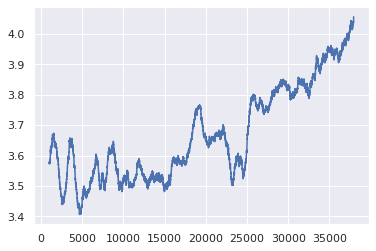

In [76]:
from pandas import Series
import matplotlib.pyplot as plt

plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

In [83]:
import random 

random.shuffle(data)
star_ratings = [row['stars'] for row in data]

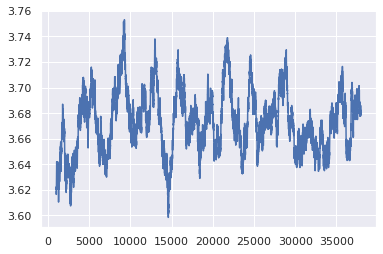

In [84]:
plt.plot(Series.rolling(Series(star_ratings), window=1000).mean());

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline


knn = KNeighborsRegressor(n_neighbors=78)

piped = Pipeline([
    ('to_frame', ToDataFrame()),
    ('features', selector),
    ('regressor', knn)
    ])

lat_long_model = GridSearchCV(piped, '')

lat_long_model.fit(data, star_ratings)

Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('encoder', 'passthrough',
                                                  ['latitude']),
                                                 ('encoders', 'passthrough',
                                                  ['longitude'])])),
                ('regressor', KNeighborsRegressor(n_neighbors=78))])

## Category Model

While location is important, we could also try seeing how predictive the
venue's category is. We will build an estimator that considers only the `'categories'` field of the data.

The categories come as a list of strings, but the scikit-learn's predictors all need numeric input. We ultimately want to create a column in our feature matrix to represent every category. For a given row, only the columns that represent the categories it contains will be filled with a one, otherwise, it will be filled with a zero. The described method is similar to **one-hot encoding**, however, an observation/row can contain more than one "hot", non-zero, column.

To achieve our encoding plan, we need to use scikit-learn's provides [`DictVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html#sklearn.feature_extraction.DictVectorizer). This transformer takes a 1-D array of dictionaries and creates a column in the output matrix for each key in the dictionary and fills it with the value associated with it. Missing keys are filled with zeros. However, we need to build a transformer that takes an array of strings and returns an array of dictionaries with keys given by those strings and values of one. For example, it should transform `X_in` into `X_out`.

In [89]:
X_in = pd.Series([['a'], ['b', 'c']])
X_out = pd.Series([{'a': 1}, {'b': 1, 'c': 1}])

print(type(X_in))
print(X_out)

<class 'pandas.core.series.Series'>
0            {'a': 1}
1    {'b': 1, 'c': 1}
dtype: object


In [92]:
opo = DictEncoder().fit_transform(X_in)
opo

[{'a': 1}, {'b': 1, 'c': 1}]

In [93]:
from sklearn.feature_extraction import DictVectorizer

DictVectorizer(sparse=False).fit_transform(opo)

array([[1., 0., 0.],
       [0., 1., 1.]])

In [94]:
type(X_out)

pandas.core.series.Series

In [95]:
selector = ColumnTransformer([('encoder', 'passthrough', ['latitude']), ('encoders', 'passthrough', ['longitude'])])

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

param_grid = {'n_neighbors': [3,5,11,19,21]}
gs = GridSearchCV(KNeighborsRegressor(), param_grid)

lat_long_model = Pipeline([
    ('to_frame', ToDataFrame()),
    ('features', selector),
    ('gs_est', gs)
    ])

lat_long_model.fit(data, star_ratings)

Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('encoder', 'passthrough',
                                                  ['latitude']),
                                                 ('encoders', 'passthrough',
                                                  ['longitude'])])),
                ('gs_est',
                 GridSearchCV(estimator=KNeighborsRegressor(),
                              param_grid={'n_neighbors': [3, 5, 11, 19, 21]}))])

In [96]:
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin

class DictEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # X will be a pandas series. Return a pandas series of dictionaries
        z = []
        for i in X:
            leng = len(i)
            x = [1] * leng
            d1 = dict(zip(i, x))
            z.append(d1)
        return z

Now, we will create a pipeline object of the two step transformation for the categories data. Afterwards, we will create a `ColumnTransformer` object that will use the aforementioned pipeline object to transform the `'categories'` field.

Finally, we will create a pipeline object that will
1. Convert our list of dictionaries into a data frame
1. Select the `'categories'` column and encode the data
1. Train a regularized linear model such as `Ridge`

There will be a large number of features, one for each category, so there is a significant danger of overfitting. We will use cross validation to choose the best regularization parameter.

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.feature_extraction import DictVectorizer

categorical_columns = ['categories']  

params_Ridge = {'alpha': [1, 0.1, 0.01, 0.001]}

Ridge_GS = GridSearchCV(Ridge(), param_grid=params_Ridge)

piper = Pipeline([
    ('dict_encode', DictEncoder()),
    ('dictvect', DictVectorizer(sparse=False))
])

features = ColumnTransformer([('categorical', piper, 'categories')], remainder='drop')

category_model = Pipeline([
    ('to_frame', ToDataFrame()),
    ('features', features),
    ('ridgg', Ridge_GS)
])
    
category_model.fit(data, star_ratings)

Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('dict_encode',
                                                                   DictEncoder()),
                                                                  ('dictvect',
                                                                   DictVectorizer(sparse=False))]),
                                                  'categories')])),
                ('ridgg',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': [1, 0.1, 0.01, 0.001]}))])

In [99]:
rex = data[:5]
rex

[{'business_id': 'uoAMNAs6Bcvbl8v9Q97V6Q',
  'full_address': '111 E  Dunlap Ave\nSte 113-115\nPhoenix, AZ 85020',
  'hours': {'Monday': {'close': '12:00', 'open': '05:30'},
   'Tuesday': {'close': '18:00', 'open': '05:30'},
   'Friday': {'close': '20:00', 'open': '05:30'},
   'Wednesday': {'close': '18:00', 'open': '05:30'},
   'Thursday': {'close': '18:00', 'open': '05:30'},
   'Sunday': {'close': '12:00', 'open': '05:30'},
   'Saturday': {'close': '20:00', 'open': '05:30'}},
  'open': True,
  'categories': ['Bakeries', 'Food'],
  'city': 'Phoenix',
  'review_count': 13,
  'name': "Karl's Quality Bakery",
  'neighborhoods': [],
  'longitude': -112.0722814,
  'state': 'AZ',
  'stars': 5.0,
  'latitude': 33.5677316,
  'attributes': {'Parking': {'garage': False,
    'street': False,
    'validated': False,
    'lot': True,
    'valet': False},
   'Accepts Credit Cards': True,
   'Price Range': 1},
  'type': 'business'},
 {'business_id': 'O16EckCLtNoA49hewGht_w',
  'full_address': '6516 U

In [103]:
rexov = ToDataFrame().fit_transform(rex)

In [104]:
rexov['categories']

0                                     [Bakeries, Food]
1                     [Tires, Automotive, Auto Repair]
2                     [Fashion, Shopping, Shoe Stores]
3    [Car Wash, Automotive, Convenience Stores, Foo...
4                               [Mexican, Restaurants]
Name: categories, dtype: object

In [105]:
rexoviov = DictEncoder().fit_transform(rexov['categories'])

In [106]:
DictVectorizer(sparse=False).fit_transform(rexoviov)

array([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.],
       [0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.]])

Some categories (e.g., Restaurants) are not very specific. Others (Japanese sushi) are much more so.  One way to deal with this is with an measure call term frequency-inverse document frequency (tf-idf). Add in a [`TfidfTransformer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) between the `DictVectorizer` and the linear model, and see if that improves performance.

## Attribute Model

There is even more information in the attributes for each venue.  Let's build an estimator based on these.

Venues attributes may be nested:
```python
{
  'Attire': 'casual',
  'Accepts Credit Cards': True,
  'Ambiance': {'casual': False, 'classy': False}
}
```
We wish to encode them in the same manner as our categories data using the `DictVectorizer`. Before we do so, we need to flatten the dictionary to a single level:
```python
{
  'Attire_casual' : 1,
  'Accepts Credit Cards': 1,
  'Ambiance_casual': 0,
  'Ambiance_classy': 0
}
```
We will build a custom transformer that flattens the dictionary for the `'attributes'` field. Similar to what was done before, we will create a model that properly encodes the attribute data and learns to predict the ratings.

In [108]:
import collections

class AttributeFlattener(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):          
        
        return [self.flatten(x) for x in X]
    
    def flatten(self, X, parent_key='', sep='_'):
        items = []
        for k, v in X.items():
            new_key = parent_key + sep + k if parent_key else k
            if isinstance(v, collections.MutableMapping):
                items.extend(self.flatten(v, new_key, sep=sep).items())
            else:
                items.append((new_key, v))
        return dict(items)

In [109]:
x = data[:5]

In [110]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction import DictVectorizer

piper = Pipeline([('Flattened', AttributeFlattener()), 
                  ('dictvect', DictVectorizer(sparse=False))
                 ])

features = ColumnTransformer([('attFlattener', piper, 'attributes')], remainder='drop')

In [111]:
# Create the linear + non-linear ensemble predictor

params_Ridge = {'alpha': [1, 0.1, 0.01, 0.001]}

Ridge_GS = GridSearchCV(Ridge(), param_grid=params_Ridge)

linear_model= Pipeline([('to_frame', ToDataFrame()),
                   ('features', features),
                   ('ridgg', Ridge_GS)
                  ])

linear_model.fit(data, star_ratings)

<ipython-input-108-f5265c96079d>:16: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.9 it will stop working
  if isinstance(v, collections.MutableMapping):


Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('attFlattener',
                                                  Pipeline(steps=[('Flattened',
                                                                   AttributeFlattener()),
                                                                  ('dictvect',
                                                                   DictVectorizer(sparse=False))]),
                                                  'attributes')])),
                ('ridgg',
                 GridSearchCV(estimator=Ridge(),
                              param_grid={'alpha': [1, 0.1, 0.01, 0.001]}))])

In [112]:
linear_model.predict(data)

array([3.79020335, 3.70723665, 3.6125442 , ..., 3.70590009, 3.8994255 ,
       3.78228389])

In [113]:
# non-linear ensemble predictor

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

regr = RandomForestRegressor(max_depth=20, random_state=42)

residual_star_ratings = np.array(star_ratings) - linear_model.predict(data)

non_linear_model = Pipeline([('to_frame', ToDataFrame()),
                   ('features', features),
                   ('RF', regr)                 
                  ])

non_linear_model.fit(data, residual_star_ratings)

Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('attFlattener',
                                                  Pipeline(steps=[('Flattened',
                                                                   AttributeFlattener()),
                                                                  ('dictvect',
                                                                   DictVectorizer(sparse=False))]),
                                                  'attributes')])),
                ('RF', RandomForestRegressor(max_depth=20, random_state=42))])

In [115]:
non_linear_model.predict(data)

array([-0.12820352, -0.02486148, -0.13666532, ..., -0.05184038,
        0.15666737, -0.0070458 ])

In [114]:
# Create the attribute model

class AttributeModel(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        linear_model.fit(X, y)
        residual_y = np.array(y) - linear_model.predict(X)
        non_linear_model.fit(X, residual_y)
        return self
    
    def predict(self, X):
        return linear_model.predict(X) + non_linear_model.predict(X)
    
attribute_model = AttributeModel()
print(attribute_model.predict(data[:5]) - np.array(star_ratings)[:5])

[-1.33800017 -1.31762483 -1.02412112  0.70507312  0.25597745]


In [116]:
attribute_model.predict(data[:5])

array([3.66199983, 3.68237517, 3.47587888, 3.70507312, 3.75597745])

In [118]:
from sklearn import set_config
set_config(display='diagram')

non_linear_model

Pipeline(steps=[('to_frame', ToDataFrame()),
                ('features',
                 ColumnTransformer(transformers=[('attFlattener',
                                                  Pipeline(steps=[('Flattened',
                                                                   AttributeFlattener()),
                                                                  ('dictvect',
                                                                   DictVectorizer(sparse=False))]),
                                                  'attributes')])),
                ('RF', RandomForestRegressor(max_depth=20, random_state=42))])

## Full Model

So far we have only built models based on individual features.  Now we will build an ensemble regressor that averages together the estimates of the four previous regressors.

In order to use the existing models as input to a predictor, we will have to turn them into transformers; a predictor can only be in the final step of a pipeline. We will build a custom `ModelTransformer` class that takes a predictor as an argument. When `fit` is called, the predictor should be fit. When `transform` is called, the predictor's `predict` method should be called, and its results returned as the transformation.

Note that the output of the `transform` method should be a 2-D array with a single column in order for it to work well with the scikit-learn pipeline. If you're using NumPy arrays, you can use `.reshape(-1, 1)` to create a column vector. If you are just using Python lists, you will want a list of lists of single elements.

In [119]:
class ModelTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, model):
        # What needs to be done here?
        self.model = model
    
    def fit(self, X, y):
        # Fit the stored predictor.
        # Question: what should be returned?
        return self
            
    def transform(self, X):
        # Use predict on the stored predictor as a "transformation".
        # Be sure to return a 2-D array.
        return (np.array(self.model.predict(X))).reshape(-1,1)

In [120]:
ModelTransformer(city_model)

ModelTransformer(model=CityRegressor())

Let's now test it out on our `city_model`.

In [122]:
ModelTransformer(lat_long_model)

ModelTransformer(model=Pipeline(steps=[('to_frame', ToDataFrame()),
                                       ('features',
                                        ColumnTransformer(transformers=[('encoder',
                                                                         'passthrough',
                                                                         ['latitude']),
                                                                        ('encoders',
                                                                         'passthrough',
                                                                         ['longitude'])])),
                                       ('gs_est',
                                        GridSearchCV(estimator=KNeighborsRegressor(),
                                                     param_grid={'n_neighbors': [3,
                                                                                 5,
                                                                                 11,
                                                                                 19,
                                                                                 21]}))]))

Create an instance of `ModelTransformer` for each of the previous four models. Combine these together in a single feature matrix with a
[`FeatureUnion`](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.FeatureUnion.html#sklearn.pipeline.FeatureUnion).

In [124]:
from sklearn.pipeline import FeatureUnion

union = FeatureUnion([('city_model', ModelTransformer(city_model)),
                      ('lat_long_model', ModelTransformer(lat_long_model)), 
                      ('category_model', ModelTransformer(category_model)),
                      ('linear_model', ModelTransformer(attribute_model))])

In [125]:
union.fit(data, star_ratings)
X_t = union.transform(data[:5])

In [126]:
X_t

array([[3.67029039, 3.66666667, 3.8328489 , 3.66199983],
       [3.61111111, 3.69047619, 3.72421276, 3.68237517],
       [3.82067576, 3.76190476, 3.6943262 , 3.47587888],
       [3.6446213 , 3.57142857, 2.85528509, 3.70507312],
       [3.6446213 , 3.33333333, 3.51209581, 3.75597745]])

Our `FeatureUnion` object should return a feature matrix with four columns.

Finally, use a pipeline to combine the feature union with a linear regression (or another model) to weight the predictions.

In [128]:
from sklearn.linear_model import LinearRegression

full_model = Pipeline([('union',union),
                     ('LinReg',LinearRegression())])

full_model.fit(data, star_ratings)

Pipeline(steps=[('union',
                 FeatureUnion(transformer_list=[('city_model',
                                                 ModelTransformer(model=CityRegressor())),
                                                ('lat_long_model',
                                                 ModelTransformer(model=Pipeline(steps=[('to_frame',
                                                                                         ToDataFrame()),
                                                                                        ('features',
                                                                                         ColumnTransformer(transformers=[('encoder',
                                                                                                                          'passthrough',
                                                                                                                          ['latitude']),
                                                                                                                         ('encoders',
                                                                                                                          'passthrough',
                                                                                                                          ['longitude'])])),
                                                                                        ('gs_est',
                                                                                         GridSearchCV(estim...
                                                                                         ToDataFrame()),
                                                                                        ('features',
                                                                                         ColumnTransformer(transformers=[('categorical',
                                                                                                                          Pipeline(steps=[('dict_encode',
                                                                                                                                           DictEncoder()),
                                                                                                                                          ('dictvect',
                                                                                                                                           DictVectorizer(sparse=False))]),
                                                                                                                          'categories')])),
                                                                                        ('ridgg',
                                                                                         GridSearchCV(estimator=Ridge(),
                                                                                                      param_grid={'alpha': [1,
                                                                                                                            0.1,
                                                                                                                            0.01,
                                                                                                                            0.001]}))]))),
                                                ('linear_model',
                                                 ModelTransformer(model=AttributeModel()))])),
                ('LinReg', LinearRegression())])